# Understanding recurrent neural network

To understand recurrent neural network clearly, let's implement the forward pass of a toy RNN in Numpy.

This RNN takes as input a sequence of vectors, which we will encode as a 2D tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep, it considers its current state at t, the input at t, and combines them to obtain the output at t. We then set the state for next step to simply be this previous output. For the very first timestep, the "previous output" is not defined, hence there is no "current state", so we will initialize the state as an all-zero vector, called the "initial state" of the network. 

In pseudo code, this is our RNN:

```python
state_t = 0 # This is the state at t.
for input_t in input_sequence: # we iterate over sequence elements.
    output_t = f(input_t, state_t) # `f` is our "step function"
    state_t = output_t # The previous output becomes the new state
```


We can even flesh out a bit the function f: the transformation of the input and state into an output will be parameterized by two matrices, W and U, and a bias vector. It's very similar to the transformation operated by a densely connected layer in a feedforward network.

```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

To make these notions absolutely unambiguous, let's go ahead and write down a naive Numpy implementation of the forward pass of our simple RNN.

In [6]:
import numpy as np

timesteps = 100 # Number of tiemsteps in the input sequence
input_features = 32 # Dimensionality of the input feature space
output_features = 64 # Dimensionality of the output feature space

# This is our input data - just random noise for the sake of our example.
inputs = np.random.random((timesteps, input_features))

# This is our "initial state": an all-zero vector.
state_t = np.zeros((output_features, ))

# Create random weight matrices
W = np.random.random((input_features, output_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs: # input_t is a vector of shape (input_features, )
    # We combine the input with the current state
    output_t = np.tanh(np.dot(np.transpose(W), input_t) + np.dot(U, state_t) + b)
    
    # We store this output in a list.
    successive_outputs.append(output_t)
    
    # We update the "state" of the network for the next timestep
    state_t = output_t
    
# The final output is a 2D tensor of shape (timesteps, output_features).
final_output_sequence = np.concatenate(successive_outputs, axis=0)
    

In [13]:
final_output_sequence.shape, type(inputs), inputs.shape

((6400,), numpy.ndarray, (100, 32))

In [14]:
for sample in inputs:
    print(sample)

[0.72625606 0.54396691 0.32645263 0.70651336 0.38016389 0.72946323
 0.65696901 0.31977903 0.29871059 0.01180269 0.21376658 0.79621093
 0.13674087 0.51731973 0.16582957 0.04709945 0.71589745 0.91072205
 0.53653045 0.67741869 0.79519518 0.46430547 0.08006601 0.45257053
 0.33680331 0.69595712 0.73172395 0.21507989 0.31760301 0.66683265
 0.29449448 0.71177921]
[5.64730958e-01 7.17687699e-01 1.38591669e-01 6.24558671e-01
 9.54036379e-01 1.10657073e-01 2.64439514e-01 1.89941555e-01
 2.87827845e-01 1.06843710e-01 4.84682732e-01 6.49323958e-01
 3.62996872e-01 5.15833802e-05 7.74620702e-01 6.71813017e-01
 3.75456306e-01 1.60008511e-01 4.33437048e-01 7.49477873e-01
 5.76516223e-01 8.79993301e-01 4.00394093e-01 7.97422303e-01
 8.67749538e-01 8.63759859e-01 5.07728466e-01 6.06241752e-01
 7.13682291e-01 1.54785637e-01 1.69802156e-01 8.63780282e-01]
[0.87410837 0.15149909 0.68954332 0.4298404  0.85160759 0.92345961
 0.79906897 0.08279119 0.16840728 0.02042016 0.33267277 0.01645941
 0.43415551 0.5070

In [11]:
successive_outputs[0].shape, len(successive_outputs)

((64,), 100)

In [15]:
import numpy as np

timesteps = 100 # Number of tiemsteps in the input sequence
input_features = 32 # Dimensionality of the input feature space
output_features = 64 # Dimensionality of the output feature space
batch_size = 32 # The number of samples for each batch

# This is our input data - just random noise for the sake of our example.
inputs = np.random.random((batch_size, timesteps, input_features))

# This is our "initial state": an all-zero vector.
state_t = np.zeros((batch_size, output_features))

# Create random weight matrices
W = np.random.random((input_features, output_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = np.zeros((batch_size, timesteps, output_features))
for i, sample in enumerate(inputs): # a sample
    for t, input_t in enumerate(sample): # input_t is a vector of shape (input_features, ), t means tiemstep
        # We combine the input with the current state
        output_t = np.tanh(np.dot(np.transpose(W), input_t) + np.dot(U, state_t[i]) + b)
    
        # We store this output in a list.
        successive_outputs[i, t] = output_t
    
        # We update the "state" of the network for the next timestep
        state_t[i] = output_t
    
# The final output is a 2D tensor of shape (batch_szie, timesteps, output_features).
final_output_sequence = np.zeros((batch_size, timesteps * output_features))
for i, output_i in enumerate(successive_outputs):
    final_output_sequence[i] = np.concatenate(output_i, axis=0)

In [17]:
final_output_sequence[0].shape

(6400,)

In [18]:
final_output_sequence.shape

(32, 6400)

## A first recurrent layer in Keras

The process we just natively implemented in Numpy corresponds to an actual Keras layer: 
the *SimpleRNN* layer:

```python
from keras.layers import SimpleRNN
```

_SimpleRNN_ can be run in two differenet modes: 

1. it can return either the full sequences of successice outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features),

2. it can return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features))

These two modes are controlled by the *return_sequences* constructor argument.

### Using SimpleRNN and returning the last state

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

C:\Users\tangxin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### Using SimpleRNN and returning the full state sequence

In [2]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all intermediate layers return full sequences:

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


### Let's try to use such a model on the IMDB moive review classification problem.

In [6]:
# Preparing the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # number of words to consider as features
maxlen = 50 # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 50)
input_test shape: (25000, 50)


In [7]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=60,
                   batch_size=128,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/60
20000/20000 [==============================] - 5s 258us/step - loss: 0.5959 - acc: 0.6633 - val_loss: 0.5289 - val_acc: 0.7376
Epoch 2/60
20000/20000 [==============================] - 3s 171us/step - loss: 0.3923 - acc: 0.8305 - val_loss: 0.4515 - val_acc: 0.7938
Epoch 3/60
20000/20000 [==============================] - 3s 168us/step - loss: 0.2994 - acc: 0.8748 - val_loss: 0.4335 - val_acc: 0.8022
Epoch 4/60
20000/20000 [==============================] - 3s 170us/step - loss: 0.2064 - acc: 0.9226 - val_loss: 0.4866 - val_acc: 0.7916
Epoch 5/60
20000/20000 [==============================] - 3s 166us/step - loss: 0.1233 - acc: 0.9576 - val_loss: 0.5811 - val_acc: 0.7764
Epoch 6/60
20000/20000 [==============================] - 3s 171us/step - loss: 0.0647 - acc: 0.9807 - val_loss: 0.6977 - val_acc: 0.7760
Epoch 7/60
20000/20000 [==============================] - 3s 169us/step - loss: 0.0314 - acc: 0.9919 - val_loss: 0.7758 - v

20000/20000 [==============================] - 3s 171us/step - loss: 7.5728e-06 - acc: 1.0000 - val_loss: 2.1445 - val_acc: 0.7228
Epoch 59/60
20000/20000 [==============================] - 3s 170us/step - loss: 2.0751e-07 - acc: 1.0000 - val_loss: 2.1263 - val_acc: 0.7348
Epoch 60/60
20000/20000 [==============================] - 3s 170us/step - loss: 1.1343e-07 - acc: 1.0000 - val_loss: 2.1259 - val_acc: 0.7392


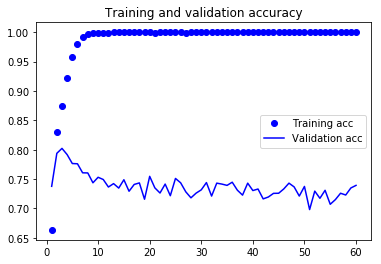

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

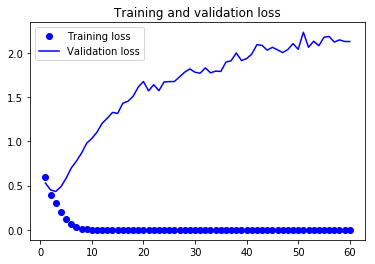

In [11]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
# Preparing the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 # number of words to consider as features
maxlen = 200 # cut texts after this number of words (among top max_features most common words)
batch_size = 64

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


In [13]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(max_features, 64))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                   epochs=60,
                   batch_size=batch_size,
                   validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/60
20000/20000 [==============================] - 71s 4ms/step - loss: 0.6436 - acc: 0.6110 - val_loss: 0.4952 - val_acc: 0.7672
Epoch 2/60
20000/20000 [==============================] - 70s 4ms/step - loss: 0.4072 - acc: 0.8262 - val_loss: 0.6581 - val_acc: 0.6638
Epoch 3/60
20000/20000 [==============================] - 71s 4ms/step - loss: 0.3207 - acc: 0.8699 - val_loss: 0.4557 - val_acc: 0.8212
Epoch 4/60
20000/20000 [==============================] - 70s 4ms/step - loss: 0.2351 - acc: 0.9099 - val_loss: 0.5114 - val_acc: 0.7898
Epoch 5/60
20000/20000 [==============================] - 70s 4ms/step - loss: 0.1484 - acc: 0.9444 - val_loss: 0.5638 - val_acc: 0.7854
Epoch 6/60
20000/20000 [==============================] - 70s 3ms/step - loss: 0.0891 - acc: 0.9677 - val_loss: 0.7315 - val_acc: 0.7368
Epoch 7/60
20000/20000 [==============================] - 70s 4ms/step - loss: 0.0579 - acc: 0.9782 - val_loss: 0.9279 - val_acc:

20000/20000 [==============================] - 71s 4ms/step - loss: 0.0029 - acc: 0.9996 - val_loss: 3.0320 - val_acc: 0.6434
Epoch 60/60
20000/20000 [==============================] - 71s 4ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 2.9622 - val_acc: 0.6562


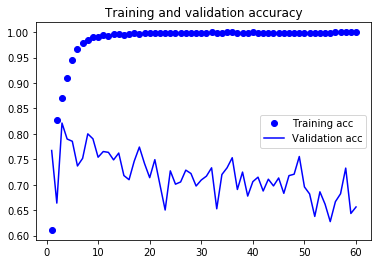

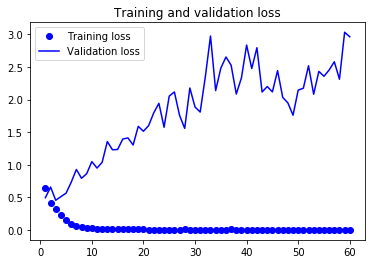

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Understanding the LSTM and GRU layers

### A concrete LSTM example in Keras

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.4767 - acc: 0.7767 - val_loss: 0.3614 - val_acc: 0.8468
Epoch 2/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.2740 - acc: 0.8935 - val_loss: 0.2999 - val_acc: 0.8780
Epoch 3/10
20000/20000 [==============================] - 99s 5ms/step - loss: 0.2270 - acc: 0.9136 - val_loss: 0.3222 - val_acc: 0.8678
Epoch 4/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.1944 - acc: 0.9277 - val_loss: 0.2889 - val_acc: 0.8792
Epoch 5/10
20000/20000 [==============================] - 99s 5ms/step - loss: 0.1723 - acc: 0.9367 - val_loss: 0.3105 - val_acc: 0.8882
Epoch 6/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.1567 - acc: 0.9426 - val_loss: 0.3378 - val_acc: 0.8832
Epoch 7/10
20000/20000 [==============================] - 97s 5ms/step - loss: 0.1466 - acc: 0.9474 - val_loss: 0.3083 - val_acc:

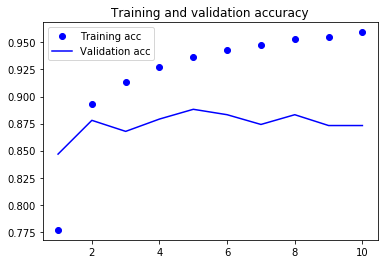

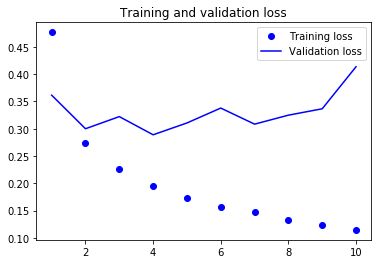

In [15]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2)

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Advanced usage of recurrent neural networks

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural networks.

We will cover the following techniques:
1. *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
2. *Stacking recurrent layers*, to increase the representational power of the network.
3. *Bidirectional recurrent layers*, which presents the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### A temperature forecasting problem

In [74]:
# inspecting the data of the jena weather dataset
import os

data_dir = 'D:/databases/jena_weather'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname, 'r') as f:
    data = f.readlines()
header = data[0].split(',')
len_data = len(data[1:])
print(header, len(header))
print(len_data)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"\n'] 15
420551


In [75]:
data[1].split(',')

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30\n']

In [76]:
import numpy as np

float_data = np.zeros((len_data, len(header) -1))
for i, line in enumerate(data[1:]):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values # We delete the date times

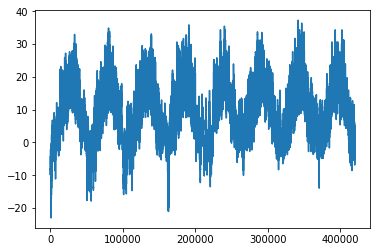

In [77]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

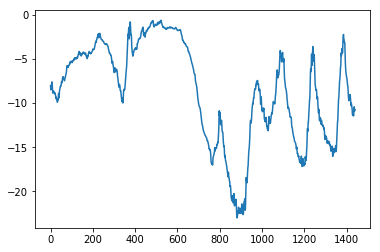

In [78]:
# we will show the change of the temporature for ten days.
# For each day, we have 24 * 6 = 144 records
plt.figure()
plt.plot(range(1440), temp[:1440])

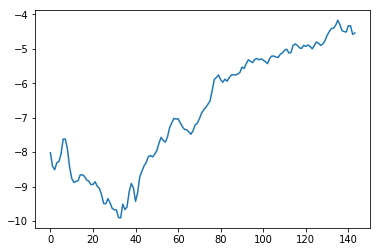

In [79]:
plt.figure()
plt.plot(range(144), temp[:144])

In [80]:
np.mean(temp[:144])

-6.7948611111111115

#### preparing the data
Given data going as far back as *lookback* timesteps (a timestep is 10 minutes) and sampled every _steps_ timesteps, can we predict the temperature in _delay_ timesteps?

We wil use the following parameter values:
* _lookback_=720, i.e. our observations will go back 5 days.
* _steps_=6, i.e. our observations will be sampled at one data point per hour.
* _delay_=144, i.e. our target will be 24 hours in the future.

To get started, we need to do two things:
* Preprocess the data to a format a neural network can ingest. Each timeseries in the data is one a different scale. So we will normalize each timeseries independently so that they all take small values on a similar scale.
* Write a python generator that takes our current array of data and yields batches of data from the recent past, alongside with a target temperature in the future.

In [81]:
# normalizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
print(std)

[ 8.48043388  8.85249908  8.95324185  7.16584991 16.72731652  7.68914559
  4.19808168  4.84034436  2.66564926  4.25206364 42.48884277  1.53666449
  2.33067298 86.61322998]


data generator
It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
* _data_: The original array of floating point data, which we just normalized in the code snippet above.
* _lookback_: How many timesteps back should our input data go.
* _delay_: How many timesteps in the future should our target be.
* *min_index* and *max_index*: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
* _shuffle_: Whether to shuffle our samples or draw them in chronological order.
* *batch_size*: The number of samples per batch.
* _step_: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every day.

In [82]:
def generator(data, lookback, delay, min_index, max_index, 
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [107]:
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [108]:
val_steps

775

In [109]:
test_steps

936

In order to evaluate the performance of a method, we define the Mean Absolute Error (MAE)
```python
np.mean(np.abs(preds - targets))
```

#### Baseline MAE

In [110]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return np.mean(batch_maes)

evaluate_naive_method()

0.2905218778760465


0.2905218778760465

In [111]:
celsius_mae = evaluate_naive_method() * std[1]

0.2905218778760465


In [112]:
celsius_mae

2.5718446572580644

#### A basic machine learning approach

In [113]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              epochs=20,
                              validation_data=val_gen,
                             steps_per_epoch=500,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 14ms/step - loss: 0.8213 - val_loss: 0.5245
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3964 - val_loss: 0.3108
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3004 - val_loss: 0.2985
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2785 - val_loss: 0.3067
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2664 - val_loss: 0.2823
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2592 - val_loss: 0.2830
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2519 - val_loss: 0.2949
Epoch 8/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2471 - val_loss: 0.2941
Epoch 9/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2432 - val_loss: 0.2855
Epoch 10/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2403 - val_lo

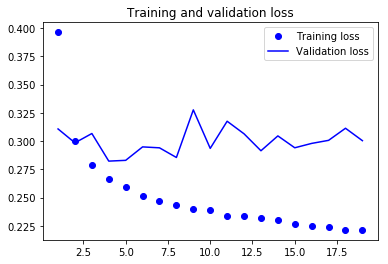

In [115]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()
plt.plot(epochs, loss[1:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### A first recurrent baseline

The first fully-connected approach didn't do so wel, but that doesn't mean machine learning is not applicable to this problem.

The approach above consisited in first flattening the timeseries, which removed the notion of time from the input data.

*GRU* layers work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run.

Epoch 1/20
500/500 [==============================] - 90s 181ms/step - loss: 0.3030 - val_loss: 0.2728
Epoch 2/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2835 - val_loss: 0.2718
Epoch 3/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2787 - val_loss: 0.2674
Epoch 4/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2726 - val_loss: 0.2645
Epoch 5/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2679 - val_loss: 0.2681
Epoch 6/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2615 - val_loss: 0.2648
Epoch 7/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2590 - val_loss: 0.2667
Epoch 8/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2545 - val_loss: 0.2714
Epoch 9/20
500/500 [==============================] - 90s 180ms/step - loss: 0.2482 - val_loss: 0.2757
Epoch 10/20
500/500 [==============================] - 90s 180ms/step - l

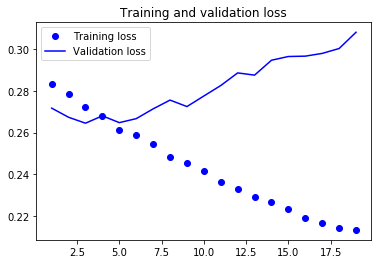

In [116]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              epochs=20,
                              validation_data=val_gen,
                             steps_per_epoch=500,
                             validation_steps=val_steps)

import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()
plt.plot(epochs, loss[1:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Using recurrent dropout to fight overfitting

Epoch 1/40
500/500 [==============================] - 100s 201ms/step - loss: 0.3554 - val_loss: 0.2770
Epoch 2/40
500/500 [==============================] - 97s 195ms/step - loss: 0.3190 - val_loss: 0.2739
Epoch 3/40
500/500 [==============================] - 103s 205ms/step - loss: 0.3105 - val_loss: 0.2705
Epoch 4/40
500/500 [==============================] - 102s 204ms/step - loss: 0.3063 - val_loss: 0.2686
Epoch 5/40
500/500 [==============================] - 104s 208ms/step - loss: 0.3044 - val_loss: 0.2731
Epoch 6/40
500/500 [==============================] - 100s 200ms/step - loss: 0.3005 - val_loss: 0.2698
Epoch 7/40
500/500 [==============================] - 98s 196ms/step - loss: 0.2980 - val_loss: 0.2665
Epoch 8/40
500/500 [==============================] - 98s 196ms/step - loss: 0.2952 - val_loss: 0.2677
Epoch 9/40
500/500 [==============================] - 98s 196ms/step - loss: 0.2938 - val_loss: 0.2653
Epoch 10/40
500/500 [==============================] - 98s 197ms/ste

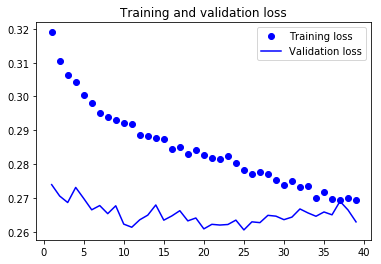

In [117]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, 
              dropout=0.2,
              recurrent_dropout=0.2,
              input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              epochs=40,
                              validation_data=val_gen,
                             steps_per_epoch=500,
                             validation_steps=val_steps)

import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()
plt.plot(epochs, loss[1:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Stacking recurrent layers

It is a generally a good idea to increase the capacity of your network until overfitting becomes your primary obstacle. As long as you are not overfitting too badly, then you are likely under-capacity.

Recurrent layer stacking is a classic way to build more powerful recurrent networks.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs rather than their output at the last timestep. 

Epoch 1/20
500/500 [==============================] - 203s 406ms/step - loss: 0.3437 - val_loss: 0.2800
Epoch 2/20
500/500 [==============================] - 200s 399ms/step - loss: 0.3213 - val_loss: 0.2751
Epoch 3/20
500/500 [==============================] - 202s 403ms/step - loss: 0.3109 - val_loss: 0.2752
Epoch 4/20
500/500 [==============================] - 209s 419ms/step - loss: 0.3081 - val_loss: 0.2749
Epoch 5/20
500/500 [==============================] - 199s 398ms/step - loss: 0.3033 - val_loss: 0.2804
Epoch 6/20
500/500 [==============================] - 201s 402ms/step - loss: 0.3017 - val_loss: 0.2659
Epoch 7/20
500/500 [==============================] - 201s 402ms/step - loss: 0.2968 - val_loss: 0.2745
Epoch 8/20
500/500 [==============================] - 201s 402ms/step - loss: 0.2923 - val_loss: 0.2680
Epoch 9/20
500/500 [==============================] - 201s 403ms/step - loss: 0.2921 - val_loss: 0.2667
Epoch 10/20
500/500 [==============================] - 202s 403m

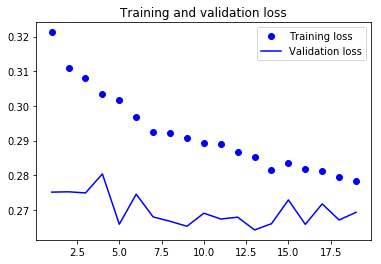

In [118]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, 
              dropout=0.1,
              recurrent_dropout=0.5,
              return_sequences=True,
              input_shape=(None, float_data.shape[-1])))
model.add(GRU(32, 
              dropout=0.1,
              recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              epochs=20,
                              validation_data=val_gen,
                             steps_per_epoch=500,
                             validation_steps=val_steps)

import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()
plt.plot(epochs, loss[1:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Using bidirectional RNNs

In [121]:
# Training and evaluating a LSTM using reversed sequences on the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential

max_features = 10000
maxlen = 50

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.5449 - acc: 0.7119 - val_loss: 0.4927 - val_acc: 0.7698
Epoch 2/10
20000/20000 [==============================] - 13s 642us/step - loss: 0.3933 - acc: 0.8238 - val_loss: 0.5013 - val_acc: 0.7674
Epoch 3/10
20000/20000 [==============================] - 13s 639us/s

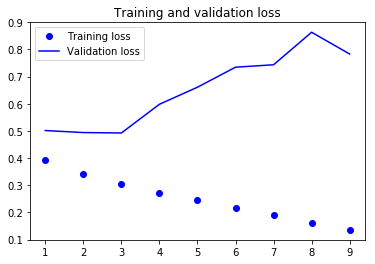

In [122]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss))

plt.figure()
plt.plot(epochs, loss[1:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [124]:
# Training and evaluating a LSTM using reversed sequences on the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.models import Sequential

max_features = 10000
maxlen = 50

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)



# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.5141 - acc: 0.7431 - val_loss: 0.4623 - val_acc: 0.7812
Epoch 2/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3613 - acc: 0.8428 - val_loss: 0.4359 - val_acc: 0.8030
Epoch 3/10
20000/20000 [==============================] - 25s 1ms/step - loss